<a href="https://colab.research.google.com/github/feranzie/Booking-flight-api/blob/main/Triage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Import libraries


In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
#from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

import warnings
import missingno as msno
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




# Explore data




In [2]:
df = pd.read_csv("/content/data.csv", sep=';', encoding='ISO-8859-1')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

In [4]:
df.describe()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Mental,Pain,KTAS_RN,Disposition,KTAS_expert,Error_group,Length of stay_min,mistriage
count,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000,1267.000
mean,1.457,1.522,54.424,7.519,2.821,1.193,1.106,0.564,3.335,1.609,3.266,0.558,11016.103,0.250
std,0.498,0.500,19.725,3.161,0.808,0.394,0.448,0.496,0.885,1.158,0.886,1.571,80446.092,0.628
min,1.000,1.000,16.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000
25%,1.000,1.000,37.000,5.000,2.000,1.000,1.000,0.000,3.000,1.000,3.000,0.000,133.000,0.000
50%,1.000,2.000,57.000,7.000,3.000,1.000,1.000,1.000,3.000,1.000,3.000,0.000,274.000,0.000
75%,2.000,2.000,71.000,10.000,3.000,1.000,1.000,1.000,4.000,2.000,4.000,0.000,606.500,0.000
max,2.000,2.000,96.000,17.000,7.000,2.000,4.000,1.000,5.000,7.000,5.000,9.000,709510.000,2.000


In [5]:
df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1
3,1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,NaN,4,Ascites,1,5,8,109,"6,60",1


In [6]:
df.isnull().sum()


,0
Group,0
Sex,0
Age,0
Patients number per hour,0
Arrival mode,0
Injury,0
Chief_complain,0
Mental,0
Pain,0
NRS_pain,0


# feature engineering


In [7]:
df['NRS_pain'].unique()

array(['2', '3', '4', '5', '6', '8', '9', '#BOÞ!', '1', '7', '10'],
      dtype=object)

In [8]:
# replace invalid  value with null
df['NRS_pain'] = df['NRS_pain'].replace('#BOÞ!', np.nan)


In [9]:
#fill missing values with mode
df["NRS_pain"] = df.groupby(["mistriage", "KTAS_expert"])["NRS_pain"].transform(lambda x: x.fillna(x.mode()[0]))
df["Saturation"] = df.groupby(["mistriage", "KTAS_expert"])["Saturation"].transform(lambda x: x.fillna(x.mode()[0]))
df["Diagnosis in ED"] = df.groupby(["mistriage", "KTAS_expert"])["Diagnosis in ED"].transform(lambda x: x.fillna(x.mode()[0]))

In [10]:
injury_cat = ['No','Yes']
sex_cat = ['Female','Male']
pain_cat = ['No','Yes']
mental_cat = ['Alert','Verbose Response','Pain Response','Unresponsive']
group_cat = ['Local ED (3th Degree)', 'Regional ED (4th Degree)']
arrival_mode_cat = ['Walking','Public Ambulance', 'Private Vehicle','Private Ambulance', 'Other','Other','Other']
disposition_cat = ['Discharge', 'Admission to Ward', 'Admission to ICU', 'Discharge', 'Transfer', 'Death', 'Surgery']
KTAS_cat = ['Emergency','Emergency','Emergency', 'Non-Emergency', 'Non-Emergency']
mistriage_cat = ['Normal Triage','Over Triage','Under Triage']
df['KTAS duration_min'] = df['KTAS duration_min'].apply(lambda x: int(float(x.replace(',', '.'))))
df['NRS_pain'] = df['NRS_pain'].apply(lambda x:int(x))

###############################################################################################################################
#Categorical data were entered as numerical data. Therefore, it was categorized again categorically to make it more meaningful.
###############################################################################################################################
df.loc[df["Sex"] == 1, "Sex"] = sex_cat[0]
df.loc[df["Sex"] == 2, "Sex"] = sex_cat[1]

df.loc[df["Injury"] == 1, "Injury"] = injury_cat[0]
df.loc[df["Injury"] == 2, "Injury"] = injury_cat[1]

df.loc[df["Pain"] == 0, "Pain"] = pain_cat[0]
df.loc[df["Pain"] == 1, "Pain"] = pain_cat[1]

df.loc[df["Mental"] == 1, "Mental"] = mental_cat[0]
df.loc[df["Mental"] == 2, "Mental"] = mental_cat[1]
df.loc[df["Mental"] == 3, "Mental"] = mental_cat[2]
df.loc[df["Mental"] == 4, "Mental"] = mental_cat[3]

df.loc[df["Group"] == 1, "Group"] = group_cat[0]
df.loc[df["Group"] == 2, "Group"] = group_cat[1]

df.loc[df["Arrival mode"] == 1, "Arrival mode"] = arrival_mode_cat[0]
df.loc[df["Arrival mode"] == 2, "Arrival mode"] = arrival_mode_cat[1]
df.loc[df["Arrival mode"] == 3, "Arrival mode"] = arrival_mode_cat[2]
df.loc[df["Arrival mode"] == 4, "Arrival mode"] = arrival_mode_cat[3]
df.loc[df["Arrival mode"] == 5, "Arrival mode"] = arrival_mode_cat[4]
df.loc[df["Arrival mode"] == 6, "Arrival mode"] = arrival_mode_cat[5]
df.loc[df["Arrival mode"] == 7, "Arrival mode"] = arrival_mode_cat[6]

df.loc[df["Disposition"] == 1, "Disposition"] = disposition_cat[0]
df.loc[df["Disposition"] == 2, "Disposition"] = disposition_cat[1]
df.loc[df["Disposition"] == 3, "Disposition"] = disposition_cat[2]
df.loc[df["Disposition"] == 4, "Disposition"] = disposition_cat[3]
df.loc[df["Disposition"] == 5, "Disposition"] = disposition_cat[4]
df.loc[df["Disposition"] == 6, "Disposition"] = disposition_cat[5]
df.loc[df["Disposition"] == 7, "Disposition"] = disposition_cat[6]

df.loc[df["KTAS_RN"] == 1, "KTAS_RN"] = KTAS_cat[0]
df.loc[df["KTAS_RN"] == 2, "KTAS_RN"] = KTAS_cat[1]
df.loc[df["KTAS_RN"] == 3, "KTAS_RN"] = KTAS_cat[2]
df.loc[df["KTAS_RN"] == 4, "KTAS_RN"] = KTAS_cat[3]
df.loc[df["KTAS_RN"] == 5, "KTAS_RN"] = KTAS_cat[4]

df.loc[df["KTAS_expert"] == 1, "KTAS_expert"] = KTAS_cat[0]
df.loc[df["KTAS_expert"] == 2, "KTAS_expert"] = KTAS_cat[1]
df.loc[df["KTAS_expert"] == 3, "KTAS_expert"] = KTAS_cat[2]
df.loc[df["KTAS_expert"] == 4, "KTAS_expert"] = KTAS_cat[3]
df.loc[df["KTAS_expert"] == 5, "KTAS_expert"] = KTAS_cat[4]

df.loc[df["mistriage"] == 0, "mistriage"] = mistriage_cat[0]
df.loc[df["mistriage"] == 1, "mistriage"] = mistriage_cat[1]
df.loc[df["mistriage"] == 2, "mistriage"] = mistriage_cat[2]
###############################################################################################################################
##############               Nonsense data was encountered in variables containing numerical data.                 ############
##############                 These values have been replaced by the mode of the variable.                        ############
###############################################################################################################################

df[["SBP","DBP","HR","RR","BT","Saturation"]] = df[["SBP","DBP","HR","RR","BT","Saturation"]].replace("??",0).astype(str).astype(float)
df['SBP'] = df['SBP'].replace(0,df['SBP'].mode()[0])
df['DBP'] = df['DBP'].replace(0,df['DBP'].mode()[0])

###############################################################################################################################
##############                                        Feature Engineering                                          ############
###############################################################################################################################
interval = (0, 25, 45, 60, 100)
cats = ['Young', 'Adult', 'Mid_Age', 'Old']
df["New_Age"] = pd.cut(df.Age, interval, labels=cats)

df.loc[df['SBP'] < 80, 'New_SBP'] = 'Low'
df.loc[(df["SBP"] >= 80) & (df["SBP"] <= 120), 'New_SBP'] = 'Normal'
df.loc[df['SBP'] > 120, 'New_SBP'] = 'High'

df.loc[df['DBP'] < 60, 'New_DBP'] = 'Low'
df.loc[(df["DBP"] >= 60) & (df["DBP"] <= 80), 'New_DBP'] = 'Normal'
df.loc[df['DBP'] > 80, 'New_DBP'] = 'High'

df.loc[df['HR'] < 45, 'New_HR'] = 'Low'
df.loc[(df["HR"] >= 45) & (df["HR"] <= 100), 'New_HR'] = 'Normal'
df.loc[df['HR'] > 100, 'New_HR'] = 'High'

df.loc[df['RR'] < 12, 'New_RR'] = 'Low'
df.loc[(df["RR"] >= 12) & (df["RR"] <= 25), 'New_RR'] = 'Normal'
df.loc[df['RR'] > 25, 'New_RR'] = 'High'

df.loc[df['BT'] < 36.4, 'New_BT'] = 'Low'
df.loc[(df["BT"] >= 36.4) & (df["BT"] <= 37.6), 'New_BT'] = 'Normal'
df.loc[df['BT'] > 37.6, 'New_BT'] = 'High'

df.loc[df['NRS_pain'] < 3, 'New_NRS_pain'] = 'Low Pain'
df.loc[(df["NRS_pain"] >= 3) & (df["NRS_pain"] <= 7), 'New_NRS_pain'] = 'Pain'
df.loc[df['NRS_pain'] > 7, 'New_NRS_pain'] = 'High Pain'

df.loc[df['KTAS duration_min'] < 10, 'New_KTAS_duration_min'] = 'Immediate'
df.loc[(df["KTAS duration_min"] >= 10) & (df["KTAS duration_min"] <= 60), 'New_KTAS_duration_min'] = 'Very Urgent'
df.loc[(df["KTAS duration_min"] >= 61) & (df["KTAS duration_min"] <= 120), 'New_KTAS_duration_min'] = 'Urgent'
df.loc[(df["KTAS duration_min"] >= 121) & (df["KTAS duration_min"] <= 240), 'New_KTAS_duration_min'] = 'Standart'
df.loc[df['KTAS duration_min'] > 240, 'New_KTAS_duration_min'] = 'Non-Urgent'

df.loc[df['Length of stay_min'] < 10, 'New_Length_of_stay_min'] = 'Immediate'
df.loc[(df["Length of stay_min"] >= 10) & (df["Length of stay_min"] <= 60), 'New_Length_of_stay_min'] = 'Very Urgent'
df.loc[(df["Length of stay_min"] >= 61) & (df["Length of stay_min"] <= 120), 'New_Length_of_stay_min'] = 'Urgent'
df.loc[(df["Length of stay_min"] >= 121) & (df["Length of stay_min"] <= 240), 'New_Length_of_stay_min'] = 'Standart'
df.loc[df['Length of stay_min'] > 240, 'New_Length_of_stay_min'] = 'Non-Urgent'

df.head()


,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain,New_KTAS_duration_min,New_Length_of_stay_min
0,Regional ED (4th Degree),Male,71,3,Private Vehicle,Yes,right ocular pain,Alert,Yes,2,160.000,100.000,84.000,18.000,36.600,100.000,Emergency,Corneal abrasion,Discharge,Non-Emergency,2,86,5,Over Triage,Old,High,High,Normal,Normal,Normal,Low Pain,Immediate,Urgent
1,Local ED (3th Degree),Female,56,12,Private Vehicle,Yes,right forearm burn,Alert,Yes,2,137.000,75.000,60.000,20.000,36.500,98.000,Non-Emergency,"Burn of hand, firts degree dorsum",Discharge,Non-Emergency,4,64,3,Over Triage,Mid_Age,High,Normal,Normal,Normal,Normal,Low Pain,Immediate,Urgent
2,Regional ED (4th Degree),Female,68,8,Public Ambulance,Yes,"arm pain, Lt",Alert,Yes,2,130.000,80.000,102.000,20.000,36.600,98.000,Non-Emergency,"Fracture of surgical neck of humerus, closed",Admission to Ward,Non-Emergency,4,862,1,Over Triage,Old,High,Normal,High,Normal,Normal,Low Pain,Immediate,Non-Urgent
3,Local ED (3th Degree),Male,71,8,Walking,No,ascites tapping,Alert,Yes,3,139.000,94.000,88.000,20.000,36.500,98.000,Non-Emergency,Alcoholic liver cirrhosis with ascites,Discharge,Non-Emergency,6,108,9,Over Triage,Old,High,High,Normal,Normal,Normal,Pain,Immediate,Urgent
4,Local ED (3th Degree),Male,58,4,Private Vehicle,No,"distension, abd",Alert,Yes,3,91.000,67.000,93.000,18.000,36.500,98.000,Non-Emergency,Ascites,Discharge,Non-Emergency,8,109,6,Over Triage,Mid_Age,Normal,Normal,Normal,Normal,Normal,Pain,Immediate,Urgent


# Outlier Anaysis

In [11]:
##################################################################################################################
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            low_limit, up_limit = outlier_thresholds(dataframe, col)
            # Filter for outliers, ignoring NaNs
            outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)]
            if not outliers.empty:  # Check if outliers DataFrame is not empty
                number_of_outliers = outliers.shape[0]
                print(col, ":", number_of_outliers)
                variable_names.append(col)
                if plot:
                    sns.boxplot(x=dataframe[col])
                    plt.show()
        else:
            print(f"{col} is not a numeric column, skipping...")
    return variable_names


In [12]:
has_outliers(df, ["Length of stay_min","Saturation","SBP","DBP","HR","RR","BT"])

Length of stay_min : 19
Saturation : 32
RR : 22
BT : 20


['Length of stay_min', 'Saturation', 'RR', 'BT']

In [13]:
outlier_column = ["Length of stay_min","Saturation","RR","BT"]
for i in outlier_column:
    replace_with_thresholds(df,i)

# Train Model

In [14]:
#One Hot Encoding and Robust Scale
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.05)
    quartile3 = variable.quantile(0.95)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [15]:
new_df = df[["Group", "Sex", "Patients number per hour", "Arrival mode", "Injury", "Mental", "Pain", "Saturation", "KTAS_RN",
"Disposition", "KTAS_expert", "Length of stay_min", "mistriage", "New_Age", "New_SBP", "New_DBP", "New_HR",
"New_RR", "New_BT", "New_NRS_pain", "New_KTAS_duration_min", "New_Length_of_stay_min"]]
new_df.head()

,Group,Sex,Patients number per hour,Arrival mode,Injury,Mental,Pain,Saturation,KTAS_RN,Disposition,KTAS_expert,Length of stay_min,mistriage,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain,New_KTAS_duration_min,New_Length_of_stay_min
0,Regional ED (4th Degree),Male,3,Private Vehicle,Yes,Alert,Yes,100.000,Emergency,Discharge,Non-Emergency,86.000,Over Triage,Old,High,High,Normal,Normal,Normal,Low Pain,Immediate,Urgent
1,Local ED (3th Degree),Female,12,Private Vehicle,Yes,Alert,Yes,98.000,Non-Emergency,Discharge,Non-Emergency,64.000,Over Triage,Mid_Age,High,Normal,Normal,Normal,Normal,Low Pain,Immediate,Urgent
2,Regional ED (4th Degree),Female,8,Public Ambulance,Yes,Alert,Yes,98.000,Non-Emergency,Admission to Ward,Non-Emergency,862.000,Over Triage,Old,High,Normal,High,Normal,Normal,Low Pain,Immediate,Non-Urgent
3,Local ED (3th Degree),Male,8,Walking,No,Alert,Yes,98.000,Non-Emergency,Discharge,Non-Emergency,108.000,Over Triage,Old,High,High,Normal,Normal,Normal,Pain,Immediate,Urgent
4,Local ED (3th Degree),Male,4,Private Vehicle,No,Alert,Yes,98.000,Non-Emergency,Discharge,Non-Emergency,109.000,Over Triage,Mid_Age,Normal,Normal,Normal,Normal,Normal,Pain,Immediate,Urgent


In [16]:
like_num = [col for col in new_df.columns if new_df[col].dtypes != 'O' and len(new_df[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df.columns if col not in like_num
                   and col not in 'mistriage']

In [17]:
for col in like_num:
    new_df[col] = robust_scaler(new_df[col])

new_df, one_hot_encodeds = one_hot_encoder(new_df, cols_need_scale)

In [18]:
X = new_df.drop('mistriage', axis=1)
y = np.ravel(new_df[['mistriage']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 357)

In [19]:
X_train.head()


,Patients number per hour,Saturation,Length of stay_min,Group_Regional ED (4th Degree),Sex_Male,Arrival mode_Private Ambulance,Arrival mode_Private Vehicle,Arrival mode_Public Ambulance,Arrival mode_Walking,Injury_Yes,Mental_Pain Response,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,KTAS_RN_Non-Emergency,Disposition_Admission to Ward,Disposition_Death,Disposition_Discharge,Disposition_Surgery,Disposition_Transfer,KTAS_expert_Non-Emergency,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_Low,New_SBP_Normal,New_DBP_Low,New_DBP_Normal,New_HR_Low,New_HR_Normal,New_RR_Low,New_RR_Normal,New_BT_Low,New_BT_Normal,New_NRS_pain_Low Pain,New_NRS_pain_Pain,New_KTAS_duration_min_Very Urgent,New_Length_of_stay_min_Non-Urgent,New_Length_of_stay_min_Standart,New_Length_of_stay_min_Urgent,New_Length_of_stay_min_Very Urgent
428,-0.500,-0.600,0.966,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False
772,-0.200,0.000,0.006,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,True,False,False,True,False,True,False,False,False
873,0.300,0.000,-0.020,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False
572,0.200,0.000,-0.013,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False
385,0.200,-0.400,0.968,True,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False


In [20]:
# hyperparameter search with  GridSearchCV.


lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

lgbm = LGBMClassifier(random_state=357)


gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 36
[LightGBM] [Info] Start training from score -0.166067
[LightGBM] [Info] Start training from score -3.049470
[LightGBM] [Info] Start training from score -2.247843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [21]:
lgbm_tuned = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 36
[LightGBM] [Info] Start training from score -0.166067
[LightGBM] [Info] Start training from score -3.049470
[LightGBM] [Info] Start training from score -2.247843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [22]:
gs_cv_lgbm.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000}

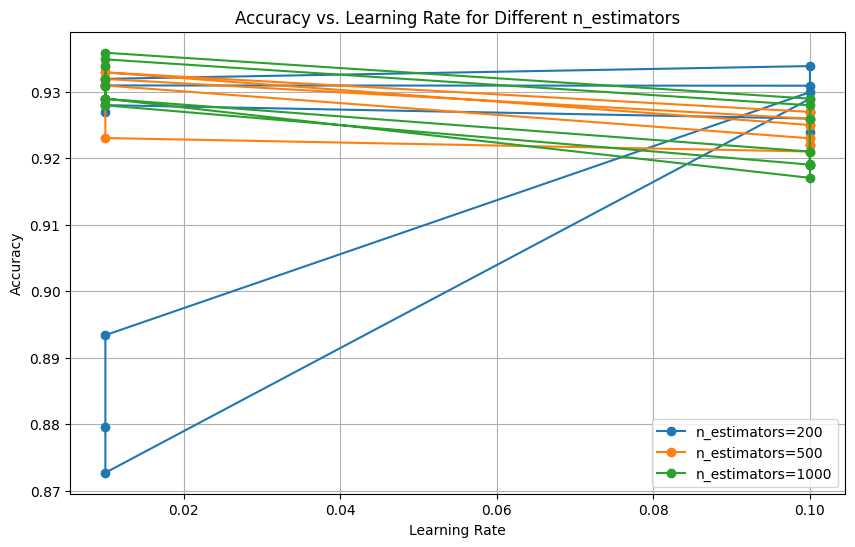

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Get the GridSearchCV results
results = gs_cv_lgbm.cv_results_

# Extract the mean test score (accuracy) and corresponding parameter (n_estimators)
n_estimators = results['param_n_estimators'].data.astype(int)
mean_test_scores = results['mean_test_score']

# Get unique values for n_estimators to plot separate lines
unique_n_estimators = np.unique(n_estimators)

# Plotting
plt.figure(figsize=(10, 6))
for n_est in unique_n_estimators:
    # Mask to select data for the current number of estimators
    mask = n_estimators == n_est
    plt.plot(results['param_learning_rate'][mask].data, mean_test_scores[mask], marker='o', label=f'n_estimators={n_est}')

plt.title('Accuracy vs. Learning Rate for Different n_estimators')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


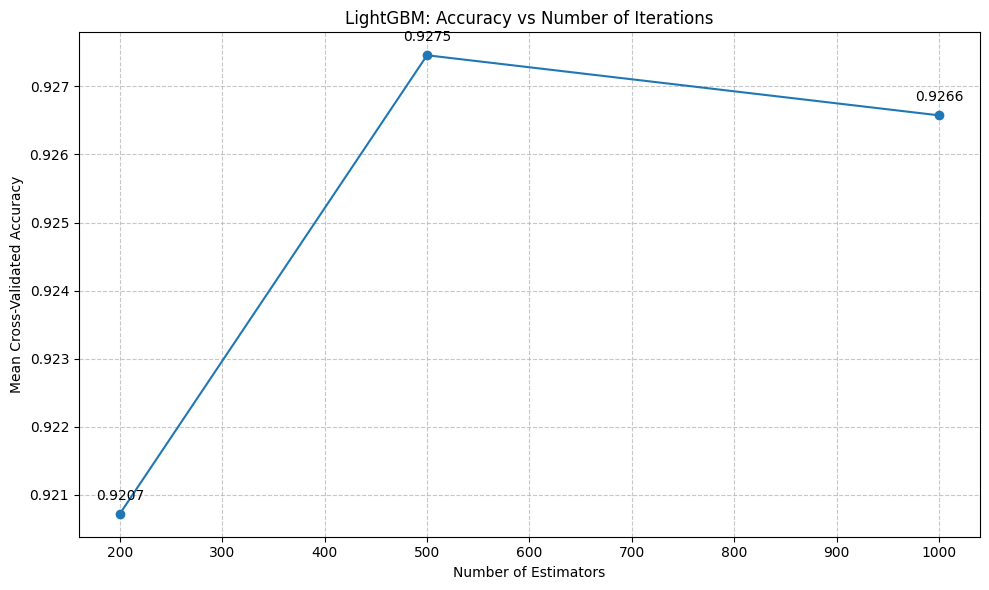

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the CV results from GridSearchCV
cv_results = gs_cv_lgbm.cv_results_

# Create a DataFrame to easily manipulate the results
results_df = pd.DataFrame(cv_results)

# Filter columns related to n_estimators and mean test score
estimators_scores = results_df[['param_n_estimators', 'mean_test_score']]

# Group by number of estimators and calculate mean accuracy
grouped_results = estimators_scores.groupby('param_n_estimators')['mean_test_score'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped_results['param_n_estimators'], grouped_results['mean_test_score'], marker='o')
plt.title('LightGBM: Accuracy vs Number of Iterations')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels
for x, y in zip(grouped_results['param_n_estimators'], grouped_results['mean_test_score']):
    plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

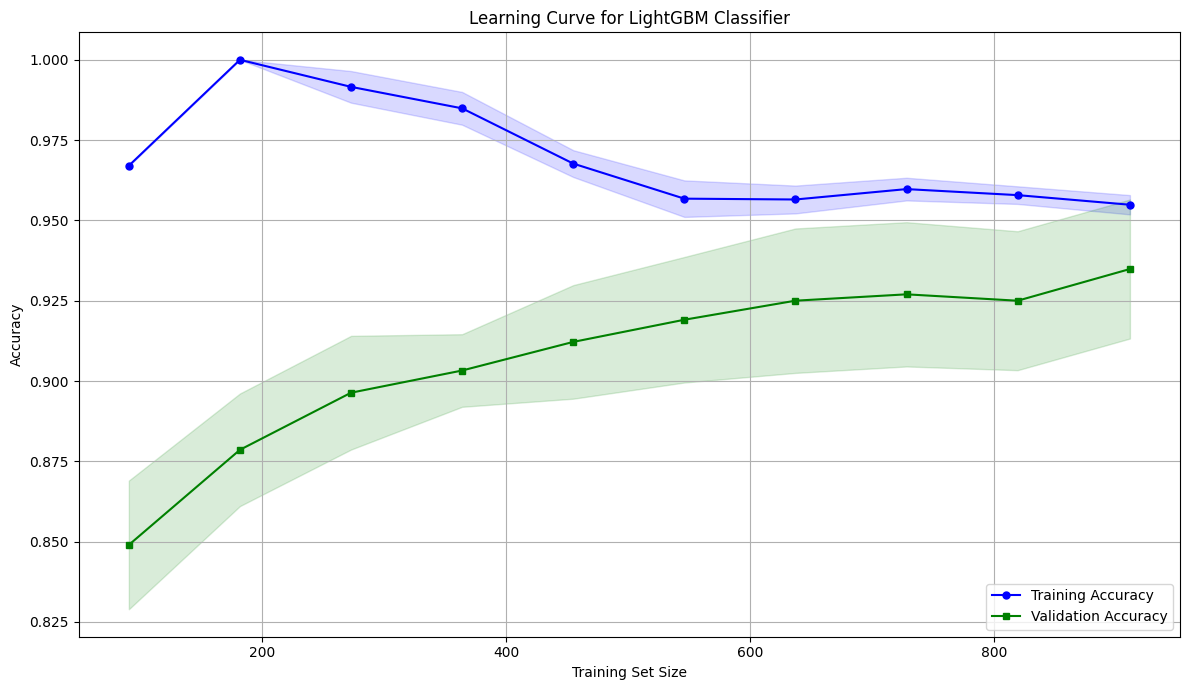

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=10):
    """
    Plot learning curve comparing training and validation accuracies

    Parameters:
    - estimator: The model (in this case, LightGBM Classifier)
    - X: Input features
    - y: Target variable
    - cv: Number of cross-validation folds
    """
    # Compute learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        train_sizes=np.linspace(0.1, 1.0, 10),  # 10 different training set sizes
        scoring='accuracy',
        n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plotting
    plt.figure(figsize=(12, 7))

    # Plot mean training scores
    plt.plot(train_sizes, train_mean, color='blue', marker='o',
             markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.15, color='blue')

    # Plot mean validation scores
    plt.plot(train_sizes, val_mean, color='green', marker='s',
             markersize=5, label='Validation Accuracy')
    plt.fill_between(train_sizes,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.15, color='green')

    plt.title('Learning Curve for LightGBM Classifier')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Use the best estimator from GridSearchCV
best_lgbm = gs_cv_lgbm.best_estimator_

# Plot the learning curve
plot_learning_curve(best_lgbm, X_train, y_train)

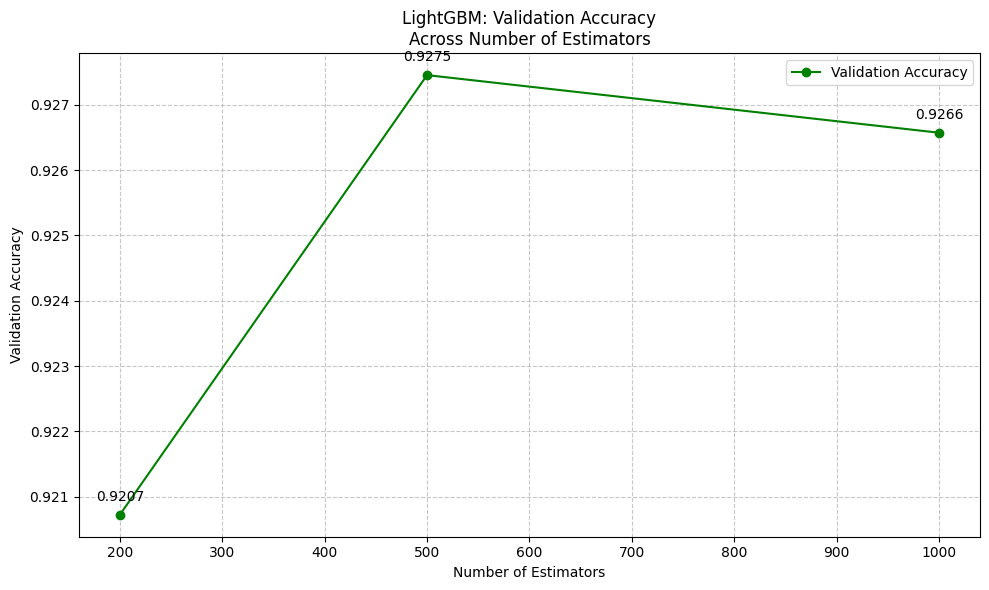

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract the CV results from GridSearchCV
cv_results = gs_cv_lgbm.cv_results_

# Create a DataFrame to easily manipulate the results
results_df = pd.DataFrame(cv_results)

# Group by number of estimators and get mean test scores
grouped_val = results_df.groupby('param_n_estimators')['mean_test_score'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped_val.index, grouped_val.values, marker='o', color='green', label='Validation Accuracy')

plt.title('LightGBM: Validation Accuracy\nAcross Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate points with accuracy values
for x, y in zip(grouped_val.index, grouped_val.values):
    plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [30]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_learning_rate', 'param_max_depth',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

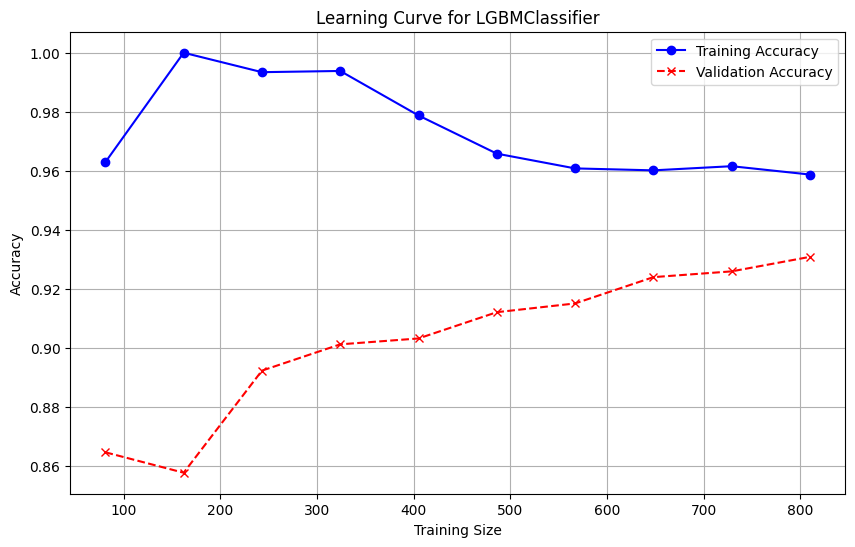

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Get learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357),
    X_train, y_train,
    cv=5,  # cross-validation splitting strategy
    scoring='accuracy',  # you can change this to 'f1', 'precision', etc.
    n_jobs=-1,  # Use all available CPUs
    train_sizes=np.linspace(0.1, 1.0, 10)  # Vary training set size
)

# Step 2: Plot Learning Curve for Accuracy
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(train_sizes, np.mean(validation_scores, axis=1), label='Validation Accuracy', color='red', linestyle='--', marker='x')

plt.title('Learning Curve for LGBMClassifier')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# Result
models = [  ("LGBM", lgbm_tuned),
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

LGBM: (0.960630)


In [ ]:
import joblib
for name, model in models:
    # Save the model
    joblib.dump(model, f'{name}_model.pkl')

    # Load the saved model
    loaded_model = joblib.load(f'{name}_model.pkl')

    # # Predict and calculate accuracy
    # y_pred = loaded_model.predict(X_test)
    # acc = accuracy_score(y_test, y_pred)
    # msg = "%s: (%f)" % (name, acc)
    # print(msg)

LGBM: (0.960630)


Confusion Matrix for LGBM:
[[223   0   0]
 [  6   1   0]
 [  4   0  20]]


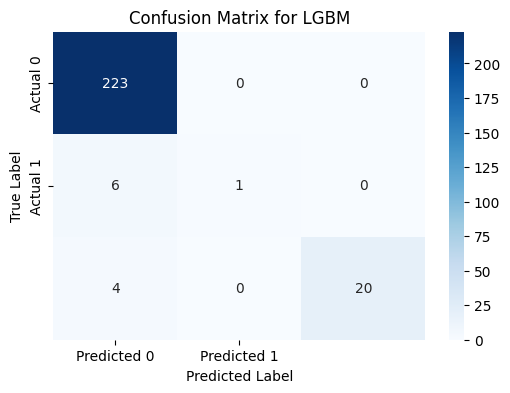

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print(f"Confusion Matrix for {name}:\n{cm}")
#visualize
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix for {name}')
plt.show()

In [ ]:
#to dos
#plot grid search results
#evaluation plots f1, recall